In [167]:
## package imports ##
import sys
import pdkit
sys.path.append("../../src")
import utils.query_utils as query
import synapseclient as sc
import matplotlib.pyplot as plt
from scipy import signal
import warnings
from scipy.fftpack import (rfft, fftfreq)
from scipy.signal import (butter, lfilter, correlate, freqz)
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import metrics
from operator import itemgetter
import time
from itertools import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.simplefilter("ignore")
sns.set_style("dark")
plt.rcParams['figure.figsize'] = [10, 5]
syn = sc.login()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [330]:
## helper functions ##


def butter_lowpass_filter(data, sample_rate, cutoff=10, order=4, plot=False):
    """
        `Low-pass filter <http://stackoverflow.com/questions/25191620/
        creating-lowpass-filter-in-scipy-understanding-methods-and-units>`_ data by the [order]th order zero lag Butterworth filter
        whose cut frequency is set to [cutoff] Hz.
        :param data: time-series data,
        :type data: numpy array of floats
        :param: sample_rate: data sample rate
        :type sample_rate: integer
        :param cutoff: filter cutoff
        :type cutoff: float
        :param order: order
        :type order: integer
        :return y: low-pass-filtered data
        :rtype y: numpy array of floats
        :Examples:
        >>> from mhealthx.signals import butter_lowpass_filter
        >>> data = np.random.random(100)
        >>> sample_rate = 10
        >>> cutoff = 5
        >>> order = 4
        >>> y = butter_lowpass_filter(data, sample_rate, cutoff, order)
    """
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    if plot:
        w, h = freqz(b, a, worN=8000)
        plt.subplot(2, 1, 1)
        plt.plot(0.5*sample_rate*w/np.pi, np.abs(h), 'b')
        plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
        plt.axvline(cutoff, color='k')
        plt.xlim(0, 0.5*sample_rate)
        plt.title("Lowpass Filter Frequency Response")
        plt.xlabel('Frequency [Hz]')
        plt.grid()
        plt.show()
    y = lfilter(b, a, data)
    return y


def zero_runs(array):
    """
    Function to search zero runs in a np.array
    parameter:
    `arr`      : np array
    returns N x 2 np array matrix containing zero runs
    format: ([start index, end index], ...)
    
    """
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(array, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

def detect_zcr(array):
    """
    function to detect zero crossing rate
    parameter:
        `array`: numpy array
    returns indexes before sign changes
    """
    zero_crossings = np.where(np.diff(np.sign(array)))[0]
    return zero_crossings

def subset_data_non_zero_runs(data, zero_runs_cutoff):
    """
    Function to subset data from zero runs heel strikes 
    that exceeded the cutoff threshold (consecutive zeros)
    parameter:
    `data`             : dataframe containing columns of chunk time and heel strikes per chunk
    `zero_runs_cutoff` : threshold of how many zeros that is eligible in each runs
    returns a non-consecutive zero runs subsetted dataframe
    """
    z_runs_threshold = []
    for value in zero_runs(data["heel_strikes"]):
        # if not moving by this duration (5 seconds)
        if (value[1]-value[0]) >= zero_runs_cutoff:
            z_runs_threshold.append(value)
    z_runs_threshold = np.array(z_runs_threshold)
    for i in z_runs_threshold:
        data = data.loc[~data.index.isin(range(i[0],i[1]))]
    return data.reset_index(drop = True)


def calculate_number_of_steps_per_window(data, orientation):
    """
    A modified function to calculate number of steps per 2.5 seconds window chunk
    parameter: 
    `filepath`    : time-series (filepath)
    `orientation` : coordinate orientation of the time series
    returns number of steps per chunk based on each recordIds
    """
    if isinstance(data,str):
        if data == "#ERROR":
            return data
        else:
            ts = query.open_filepath(data)
            ts = query.clean_accelerometer_data(ts)
            ts = ts[ts["sensorType"] == "userAcceleration"]
    
    ts = data.copy()
    window_size = 256
    step_size = 50
    jPos = window_size + 1
    i = 0
    time = []
    variances = []
    ts["filtered_%s" %orientation] = butter_lowpass_filter(ts[orientation], 
                                                               sample_rate = 100, 
                                                               cutoff = 5, order = 4)
    time = []
    heel_strikes = []
    while jPos < len(ts):
        jStart = jPos - window_size
        time.append(jPos)
        subset = ts.iloc[jStart:jPos]
        gp = pdkit.GaitProcessor(duration = subset.td[-1] - subset.td[0],
                                    cutoff_frequency = 5,
                                    filter_order = 4,
                                    delta = 0.5)
        var = subset["filtered_%s" %orientation].var()
        variances.append(var)
        try:
            if (var) < 1e-2:
                heel_strikes.append(0)
            else:
                heel_strikes.append(len(gp.heel_strikes(subset[orientation])[1]))
        except:
            heel_strikes.append(0)
        jPos = jPos + step_size
        i = i + 1
    
    ## on each time-window chunk collect data into numpy array
    heel_strikes = np.array(heel_strikes)
    variances = np.array(variances)
    ts = pd.DataFrame({"time":time, 
                        "heel_strikes":heel_strikes/(256/100), 
                        "variance": variances})
    
    ## store data size before non-consecutive zero subset
    ori_data_size = ts.shape[0]
    
    ## subset data, removing data that has 5 consecutive zero runs ##
    ts = subset_data_non_zero_runs(data = ts, zero_runs_cutoff = 5)
    
    ## store data size after consecutive zero subset
    new_data_size = ts.shape[0]
    
#     ## store data sizes percent change
#     if ori_data_size != 0:
#         data_size_pct_change = ((ori_data_size - new_data_size)/(ori_data_size))*100
    
    ## if 50% of the data is removed, we will consider the subject as not walking ##   
    if new_data_size == 0:
        return 0
    else:
        mean_heel_strikes_per_chunk = ts["heel_strikes"].mean()
        return mean_heel_strikes_per_chunk
    
    
def calculate_rotation(data, orientation):
    """
    function to calculate rotational movement gyroscope AUC * period of zero crossing
    parameter:
    `data`  : pandas dataframe
    `orient`: orientation (string)
    returns dataframe of calculation of auc and aucXt
    """
    start = 0
    dict_list = {}
    dict_list["td"] = []
    dict_list["auc"] = []
    dict_list["turn_duration"] = []
    dict_list["aucXt"] = []
    data[orientation] = butter_lowpass_filter(data = data[orientation], 
                                            sample_rate = 100, 
                                            cutoff=2, 
                                            order=2)
    zcr_list = detect_zcr(data[orientation].values)
    for i in zcr_list: 
        x = data["td"].iloc[start:i+1].values
        y = data[orientation].iloc[start:i+1].values
        turn_duration = data["td"].iloc[i+1] - data["td"].iloc[start]
        start  = i + 1
        if (len(y) >= 2):
            auc   = np.abs(metrics.auc(x,y)) 
            aucXt = auc * turn_duration
            dict_list["td"].append(x[-1])
            dict_list["turn_duration"].append(turn_duration)
            dict_list["auc"].append(auc)
            dict_list["aucXt"].append(aucXt)
    data = pd.DataFrame(dict_list)
    return data


def get_rotational_features(data):
    """
    Function to retrieve rotational features
    parameter:
    `data`: pandas dataframe
    return a dataframe containing rotational features
    """
    if isinstance(data, str):
        data = query.open_filepath(data)
        data = query.clean_accelerometer_data(data)
        data = data[data["sensorType"] == "rotationRate"]
    rotation_data = calculate_rotation(data)
    rotation_data = rotation_data[rotation_data["aucXt"] > 2]
    rotation_dict = {}
    if rotation_data.shape[0] != 0:
        rotation_dict["rotation.no_of_turns"]   = rotation_data.shape[0]
        rotation_dict["rotation.mean_duration"] = rotation_data["turn_duration"].mean()
        rotation_dict["rotation.min_duration"]  = rotation_data["turn_duration"].min()
        rotation_dict["rotation.max_duration"]  = rotation_data["turn_duration"].max()
    else:
        rotation_dict["rotation.no_of_turns"]   = 0
        rotation_dict["rotation.mean_duration"] = 0
        rotation_dict["rotation.min_duration"]  = 0
        rotation_dict["rotation.max_duration"]  = 0
    return rotation_dict



def create_overlay_data(accel_data, rotation_data):
    """
    Function to overlay acceleration data and rotational data
    """
    test = pd.merge(accel_data, rotation_data, on = "td", how = "left")
    test["time"] = test["td"]
    test = test.set_index("time")
    test.index = pd.to_datetime(test.index, unit = "s")
    test["aucXt"] = test["aucXt"].fillna(method = "bfill").fillna(0)
    test["turn_duration"] = test["turn_duration"].fillna(method = "bfill").fillna(0)
    return test


def separate_array_sequence(array):
    """
    function to separate array sequence
    parameter:
    `array`: np.array, or a list
    returns a numpy array groupings of sequences
    """
    seq2 = array
    groups = []
    for k, g in groupby(enumerate(seq2), lambda x: x[0]-x[1]):
        groups.append(list(map(itemgetter(1), g)))
    groups = np.asarray(groups)
    return groups


In [413]:
## create sampled healthcode subjects ## 


matched_demographic = query.get_file_entity(syn, "syn21482502")
gait_data = query.get_file_entity(syn = syn, synid = "syn21281633")
# gait_data = gait_data[(gait_data["version"] == "mpower_v2")]
# non_PD = gait_data[(gait_data["PD"] == 0)]["healthCode"].drop_duplicates().sample(n = 40, random_state = 100).unique()
# PD = gait_data[(gait_data["PD"] == 1)]["healthCode"].drop_duplicates().sample(n = 40, random_state = 100).unique()
hc_arr_v1 = (matched_demographic["healthCode"][matched_demographic["version"] == "mpower_v1"].unique())
query_data_v1 = query.get_walking_synapse_table(syn, 
                                                "syn10308918", 
                                                "V1", 
                                                healthCodes = hc_arr_v1) # parkinson

hc_arr_v2 = (matched_demographic["healthCode"][matched_demographic["version"] == "mpower_v2"].unique())
query_data_v2 = query.get_walking_synapse_table(syn, 
                                                "syn12514611", 
                                                "V2", 
                                                healthCodes = hc_arr_v2)

Querying V1 Data


INFO:synapseclient_default:Downloading 92370 files, 31165 cached locally


KeyboardInterrupt: 

# NOTE:
This notebook will be used to create new gait features by incorporating preliminary signal preprocessing and pdkit gait processors

List of new features:
- Number of steps per seconds based on 2.5 seconds chunking and standard deviation threshold
- Turn Duration 

In [328]:
## pipeline ## 

def pipeline(data, orientation):
    """
    Function of data pipeline for subsetting data from rotational movements, retrieving rotational features, 
    removing low-variance longitudinal data and PDKIT estimation of heel strikes based on 2.5 secs window chunks
    `data`: string of pathfile, or pandas dataframe
    returns a featurized dataframe of rotational features and number of steps per window sizes
    """
    if isinstance(data,str):
        if data == "#ERROR":
            return data
        else:
            data = query.open_filepath(data)
            data = query.clean_accelerometer_data(data)

    accel_ts    = data[data["sensorType"] == "userAcceleration"]
    rotation_ts = data[data["sensorType"] == "rotationRate"]
    rotation_ts = calculate_rotation(data = rotation_ts, 
                                     orientation = orientation)
    rotation_occurences = rotation_ts[rotation_ts["aucXt"] > 2]
    data = create_overlay_data(accel_ts, rotation_ts)
    data = data.reset_index()
    num_chunks = 1
    mean_arr_wchunk = []
    mean_arr_no_wchunk = []
    walking_seqs = separate_array_sequence(np.where(data["aucXt"]<2)[0])
    for seqs in walking_seqs:
        data_seqs = data.loc[seqs[0]:seqs[-1]]
        no_of_steps_per_secs_wchunk = calculate_number_of_steps_per_window(data = data_seqs.set_index("time"), 
                                                                           orientation = orientation)
        mean_arr_wchunk.append(no_of_steps_per_secs_wchunk)
        duration = (data_seqs["td"].iloc[-1] - data_seqs["td"].iloc[0])
        gp = pdkit.GaitProcessor(duration = duration,
                                cutoff_frequency = 5,
                                filter_order = 4,
                                delta = 0.5)  
        try:
            no_of_steps_per_secs_no_wchunk = len(gp.heel_strikes(data_seqs["y"])[0])/duration
        except:
            no_of_steps_per_secs_no_wchunk = 0
        mean_arr_no_wchunk.append(no_of_steps_per_secs_no_wchunk)
    wchunk_mean_no_of_steps_per_secs = np.mean(np.array(mean_arr_wchunk))
    no_wchunk_mean_no_of_steps_per_secs = np.mean(np.array(mean_arr_no_wchunk))
    feature_dict = {}
    feature_dict["wchunk.mean_no_of_steps_per_secs"] = wchunk_mean_no_of_steps_per_secs
    feature_dict["no_wchunk.mean_no_of_steps_per_secs"] = no_wchunk_mean_no_of_steps_per_secs
    if rotation_occurences.shape[0] != 0:
        feature_dict["rotation.no_of_turns"]   = rotation_occurences.shape[0]
        feature_dict["rotation.mean_duration"] = rotation_occurences["turn_duration"].mean()
        feature_dict["rotation.min_duration"]  = rotation_occurences["turn_duration"].min()
        feature_dict["rotation.max_duration"]  = rotation_occurences["turn_duration"].max()
    else:
        feature_dict["rotation.no_of_turns"]   = 0
        feature_dict["rotation.mean_duration"] = 0
        feature_dict["rotation.min_duration"]  = 0
        feature_dict["rotation.max_duration"]  = 0
    return feature_dict

def featurize(data):
    data["walk_features"] = data["walk_motion.json_pathfile"].apply(pipeline, orientation = "y")
    data["balance_features"] = data["balance_motion.json_pathfile"].apply(pipeline, orientation = "y")
    return data

In [331]:
# path_data["walk_features"] = path_data["walk_motion.json_pathfile"].apply(featurize)
# path_data["balance_features"] = path_data["balance_motion.json_pathfile"].apply(featurize)

if __name__ ==  '__main__': 
    start_time = time.time()
    path_data = query.parallel_func_apply(path_data, featurize, 16, 250)
    print("--- %s seconds ---" % (time.time() - start_time))

Currently running on 16 processors
--- 327.9608783721924 seconds ---


In [332]:
test = query.normalize_dict_features(path_data, "walk_features")
test = query.normalize_dict_features(test, "balance_features")
feature_columns = [feat for feat in test.columns if ("features" in feat) and ("0" not in feat)]
metadata = ["healthCode", "recordId"]
test = pd.concat([test[metadata], test[feature_columns]], axis = 1) 
test = test[(test != "#ERROR").all(axis = 1)]
for feat in feature_columns:
    test[feat] = pd.to_numeric(test[feat])

In [333]:
test = test[(test["balance_features.rotation.no_of_turns"] >= 1) & (test["walk_features.rotation.no_of_turns"] >= 1)]
# test = test[test["walk_features.wchunk.mean_no_of_steps_per_secs"] >= 1]

In [334]:
test_df = test.groupby("healthCode").mean().reset_index()
test_df = pd.merge(gait_data[["healthCode", "class", "age"]].drop_duplicates(keep = "last"), test_df, on = "healthCode", how = "inner")

In [335]:
test_df.groupby("class").mean()

,age,walk_features.wchunk.mean_no_of_steps_per_secs,walk_features.no_wchunk.mean_no_of_steps_per_secs,walk_features.rotation.no_of_turns,walk_features.rotation.mean_duration,walk_features.rotation.min_duration,walk_features.rotation.max_duration,balance_features.wchunk.mean_no_of_steps_per_secs,balance_features.no_wchunk.mean_no_of_steps_per_secs,balance_features.rotation.no_of_turns,balance_features.rotation.mean_duration,balance_features.rotation.min_duration,balance_features.rotation.max_duration
class,,,,,,,,,,,,,
mpower_v2_case,65.0,0.904968,1.052972,2.204677,2.520422,2.272097,2.813057,0.052410,0.447158,1.261722,4.540086,4.336692,4.747307
mpower_v2_control,40.4,0.857739,0.981352,2.784872,2.455682,2.074019,2.894151,0.030124,0.361659,1.181111,4.239189,4.177821,4.297732


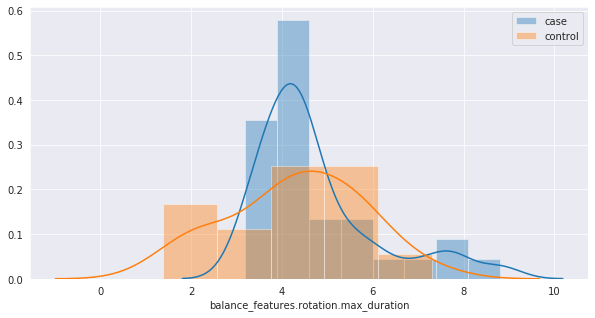

In [280]:
sns.distplot(test_df["balance_features.rotation.max_duration"][test_df["class"] == "mpower_v2_case"], label = "case")
sns.distplot(test_df["balance_features.rotation.max_duration"][test_df["class"] == "mpower_v2_control"], label = "control")
plt.legend()
plt.grid()
plt.show()

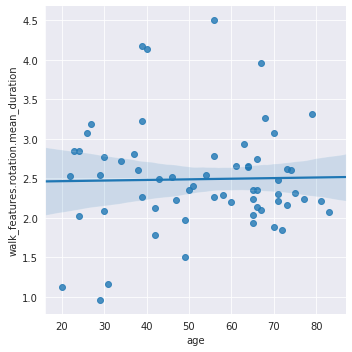

In [282]:
sns.lmplot(x = "age", y = "walk_features.rotation.mean_duration", data = test_df)
plt.grid()

In [409]:
matched_demographic = query.get_file_entity(syn, "syn21482502")

In [408]:
demographic

,healthCode,version,age,PD,nrecords,male,iPhone 4S,iPhone 5,iPhone 6,iPhone 6+,...,iPhone 6S+,iPhone 7,iPhone 7+,iPhone 8,iPhone 8+,iPhone SE,iPhone X,distance,weights,is_version2
11,9f480808-14ad-41f5-80d4-65301dd4f64b,mpower_v2,54,1,16,1,0,0,1,0,...,0,0,0,0,0,0,0,0.341067,1,1
13,18a69b44-ac67-4778-bf61-80fb8e10c9d5,mpower_v2,26,1,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0.223342,1,1
16,b45019e7-ead8-4990-a2b7-1ac7e6a8cda5,mpower_v2,65,1,27,0,0,0,0,0,...,0,0,1,0,0,0,0,0.963068,1,1
28,d3333320-3cb3-4254-92ce-d325beebd3eb,mpower_v2,58,1,31,0,0,0,0,0,...,0,0,0,1,0,0,0,0.887634,1,1
39,4713613b-965b-4fd9-98c5-11f9fbef908c,mpower_v2,49,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0.796630,1,1
40,1544f119-e9bc-46f6-aad5-50dd411b60ec,mpower_v2,47,0,2,1,0,0,0,0,...,0,0,0,0,0,0,1,0.613578,1,1
44,e7f91456-8bba-421b-946e-0007d2c1ce1a,mpower_v2,51,1,10,0,0,0,0,0,...,0,0,0,0,0,0,1,0.815637,1,1
48,a4babab4-91e8-48b7-8428-fb7c3d37ae10,mpower_v2,67,1,189,1,0,0,0,0,...,0,0,0,0,0,0,0,0.985090,1,1
49,38fedd31-521b-4d39-a377-cfc23e81ae39,mpower_v2,49,0,2,0,0,0,0,0,...,0,0,0,1,0,0,0,0.716254,1,1
50,a0b1d375-4c7a-4d6c-a2a0-e07defd257e2,mpower_v2,61,1,14,1,0,0,0,0,...,0,0,0,0,0,0,1,0.889621,1,1
